In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mistsim as ms

In [2]:
NBINS = 8

### Load data

['ant_temp', 'freq', 'lst']


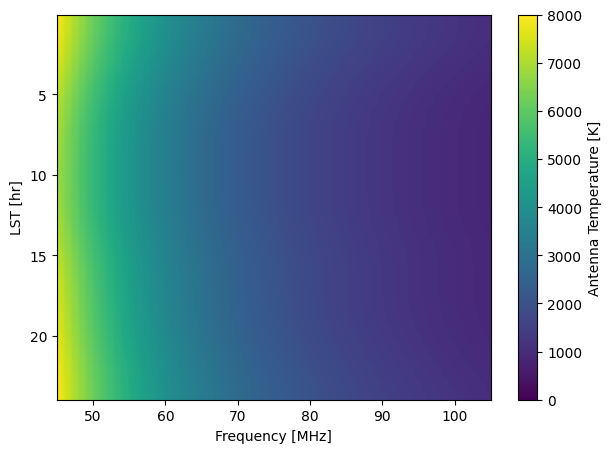

In [3]:
lst, freq, temp = ms.utils.read_hdf5_convolution(
    "../simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5",
    print_key=True,
)
indx = (freq >= 45) * (freq <= 105)
freq = freq[indx]
temp = temp[:, indx]
nspec, nfreq = temp.shape
fg_mean = temp.mean(axis=0)  # avg spectrum, fg only

plt.figure(figsize=(7,5))
im = plt.imshow(
    temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

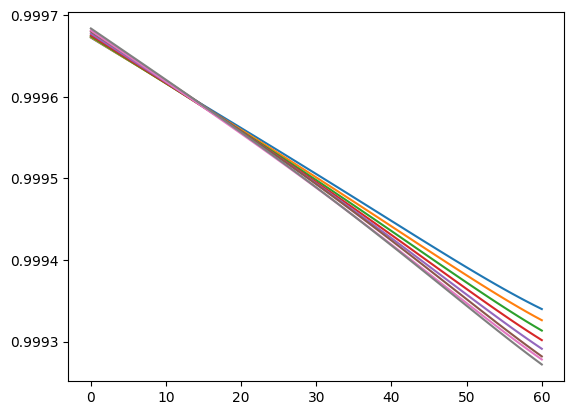

In [4]:
fg_bin = temp[:-(nspec%NBINS)].reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)  # this discards the last 6 min integration

plt.figure()
plt.plot(fg_bin.T/fg_mean[:, None])
plt.show()

### Noise

The noise covariance is taken to be diagonal. We assume systematic uncertainities have been calibrated and are left with radiometer noise. The noise in each frequency channel scales according to the radiometer equation, that is, the standard deviation is proportional to the system temperature and inversly proportional to the root of the integration time.

The first paper took the noise for the 24h avg spectrum to be 3 mK at 75 MHz and we follow that here.

In [5]:
tint_ratio = (nspec//NBINS) / nspec
noise_75 = 3e-3
t75 = fg_mean[freq == 75]
noise, sigma_inv = ms.utils.gen_noise(fg_bin, t75, ref_noise=noise_75, tint_ratio=tint_ratio)

### Foreground model

In [29]:
NFG = np.array([5, 5, 4, 5, 4, 5, 4, 5])
lst_bins = [ms.lstbin.LSTBin(freq, fg_bin[i]+noise[i], np.diag(sigma_inv[i]), 0, NFG[i]) for i in range(NBINS)]

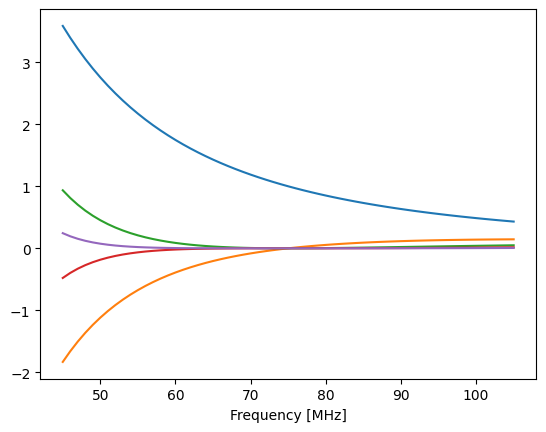

In [8]:
A = lst_bins[0].A

plt.figure()
for i in range(A.shape[1]):
    plt.plot(freq, A[:, i])
plt.xlabel("Frequency [MHz]")
plt.show()

### Fit foregrounds (linlog)

In [12]:
res_linlog = np.array([lb.bin_fg_mle(0)[1] for lb in lst_bins])

(8, 61)


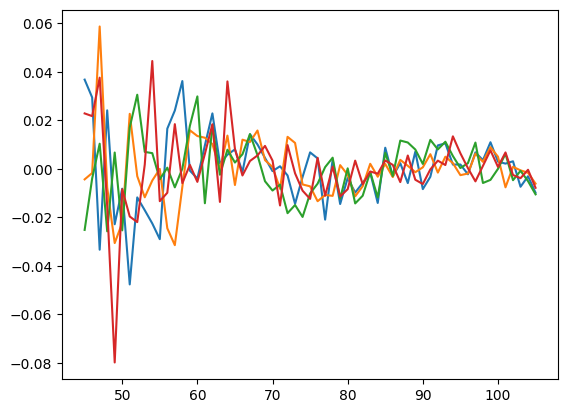

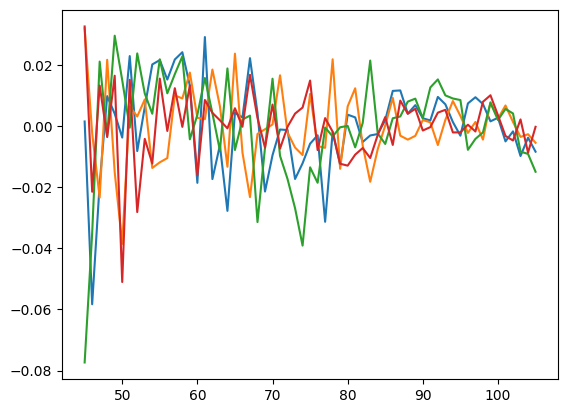

In [16]:
plt.figure()
plt.plot(freq, res_linlog.T[:, :4])
plt.show()

plt.figure()
plt.plot(freq, res_linlog.T[:, 4:])
plt.show()

In [30]:
chi2_ll = np.squeeze(res_linlog[:, None] @ np.array([np.diag(si) for si in sigma_inv]) @ res_linlog[:, :, None])
chi2_ll /= (freq.size - NFG)
print(chi2_ll)

[1.64367908 1.05405895 1.63154812 1.41692105 1.81007473 1.33513195
 2.71248613 1.05368781]


### Fit with foreground covariance eigenmodes

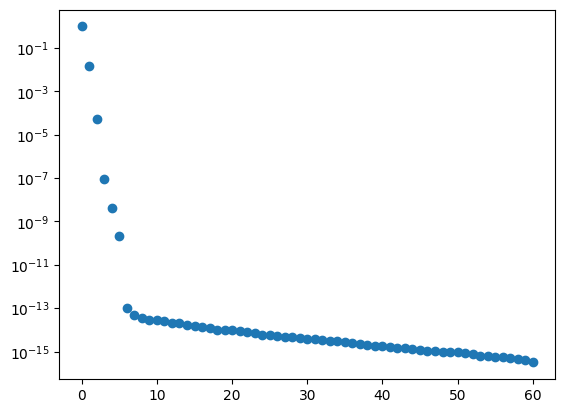

In [52]:
u, s, vt = np.linalg.svd(np.transpose(temp - fg_mean))  # cols of u are eigenvector
plt.figure()
plt.plot((s/s[0])**2, marker="o", ls="none")
plt.yscale("log")
plt.show()

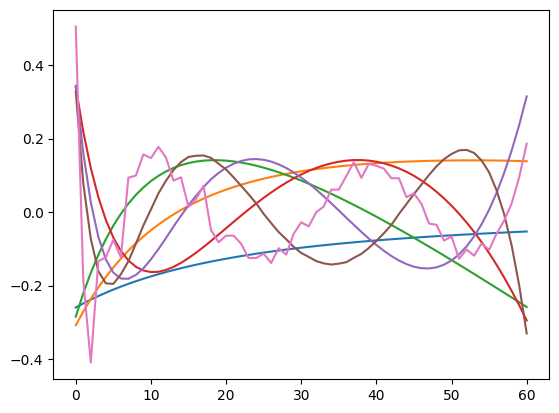

In [51]:
plt.figure()
for i in range(7):
    plt.plot(u[:, i])
plt.show()

In [55]:
for lb in lst_bins:
    lb.A = u[:, :6]
    lb.compute_covs()

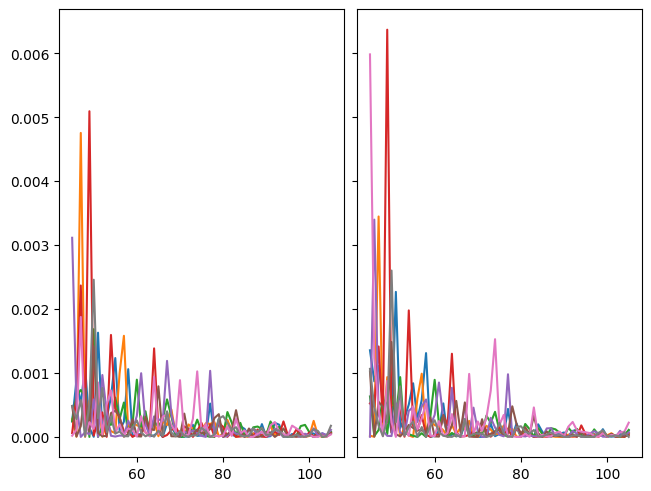

In [62]:
res_eig = np.array([lb.bin_fg_mle(0)[1] for lb in lst_bins])

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, constrained_layout=True)
axs[0].plot(freq, res_eig.T**2)#, c="k")
axs[1].plot(freq, res_linlog.T**2)#, c="blue")
plt.show()



In [67]:
chi2_eig = np.squeeze(res_eig[:, None] @ np.array([np.diag(si) for si in sigma_inv]) @ res_eig[:, :, None])
chi2_eig /= (freq.size - 6)
print(chi2_ll)
print(chi2_eig)

[1.64367908 1.05405895 1.63154812 1.41692105 1.81007473 1.33513195
 2.71248613 1.05368781]
[1.83530842 1.8447627  2.44809478 1.85536734 2.10419942 1.61144832
 2.25186329 1.80985183]


### Fitting a 21cm model

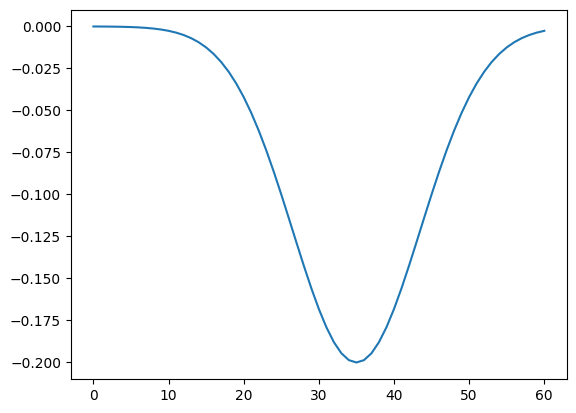

In [70]:
t21 = ms.utils.gauss(freq)
plt.figure()
plt.plot(t21)
plt.show()

In [98]:
u.shape

(61, 61)

In [99]:
t4, rll4 = ms.lstbin.fg_mle(t21, A[:, :4], np.eye(A.shape[0]), 0, 0)
t5, rll5 = ms.lstbin.fg_mle(t21, A, np.eye(A.shape[0]), 0, 0)
teig, reig = ms.lstbin.fg_mle(t21, u[:, :6], np.eye(u.shape[0]), 0, 0)

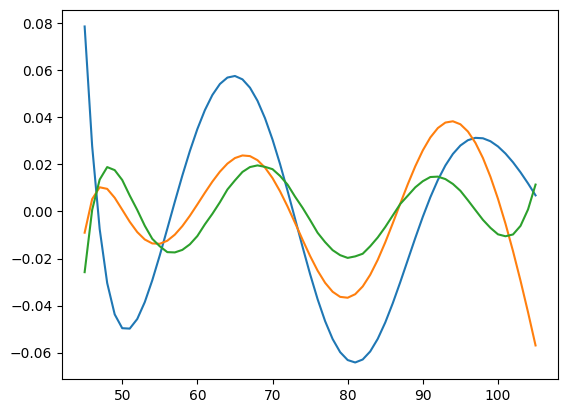

In [100]:
plt.figure()
plt.plot(freq, rll4)
plt.plot(freq, rll5)
plt.plot(freq, reig)
plt.show()

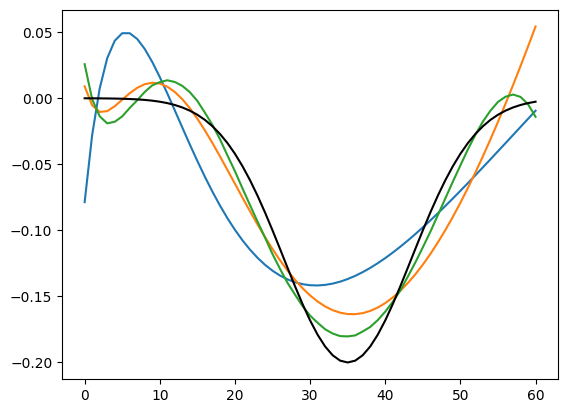

In [101]:
plt.figure()
plt.plot(A[:, :4] @ t4)
plt.plot(A @ t5)
plt.plot(u[:, :6] @ teig)
plt.plot(t21, c="k")
plt.show()